In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

base_dir = '/content/drive/MyDrive/FaceRecognitionAnti-SpoofingSystem'
folders = ['dataset', 'models', 'scripts', 'outputs']

for folder in folders:
  os.makedirs(os.path.join(base_dir, folder), exist_ok=True)

print("Folder structure created.")



Folder structure created.


In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jeanjagnus","key":"b8b8b7fde18d8154178417666595795b"}'}

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets download -d ciplab/real-and-fake-face-detection
!unzip real-and-fake-face-detection.zip -d '/content/drive/MyDrive/FaceRecognitionAnti-SpoofingSystem/dataset/'

Dataset URL: https://www.kaggle.com/datasets/ciplab/real-and-fake-face-detection
License(s): CC-BY-NC-SA-4.0
Archive:  real-and-fake-face-detection.zip
  inflating: /content/drive/MyDrive/FaceRecognitionAnti-SpoofingSystem/dataset/real_and_fake_face/training_fake/easy_100_1111.jpg  
  inflating: /content/drive/MyDrive/FaceRecognitionAnti-SpoofingSystem/dataset/real_and_fake_face/training_fake/easy_101_0010.jpg  
  inflating: /content/drive/MyDrive/FaceRecognitionAnti-SpoofingSystem/dataset/real_and_fake_face/training_fake/easy_102_0101.jpg  
  inflating: /content/drive/MyDrive/FaceRecognitionAnti-SpoofingSystem/dataset/real_and_fake_face/training_fake/easy_103_1111.jpg  
  inflating: /content/drive/MyDrive/FaceRecognitionAnti-SpoofingSystem/dataset/real_and_fake_face/training_fake/easy_104_1000.jpg  
  inflating: /content/drive/MyDrive/FaceRecognitionAnti-SpoofingSystem/dataset/real_and_fake_face/training_fake/easy_105_1100.jpg  
  inflating: /content/drive/MyDrive/FaceRecognitionAnti-

In [9]:
import os

#Checking if the files exist
data_path = '/content/drive/MyDrive/FaceRecognitionAnti-SpoofingSystem/dataset/real_and_fake_face'

print("Folders:", os.listdir(data_path))

print("Real face samples:", os.listdir(os.path.join(data_path, 'training_real'))[:5])
print("Fake face samples:", os.listdir(os.path.join(data_path, 'training_fake'))[:5])


Folders: ['training_fake', 'training_real']
Real face samples: ['real_00001.jpg', 'real_00002.jpg', 'real_00003.jpg', 'real_00004.jpg', 'real_00005.jpg']
Fake face samples: ['easy_100_1111.jpg', 'easy_101_0010.jpg', 'easy_102_0101.jpg', 'easy_103_1111.jpg', 'easy_104_1000.jpg']


In [13]:
!pip install opencv-python mtcnn dlib tensorflow keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 45.6 MB/s eta 0:00:00


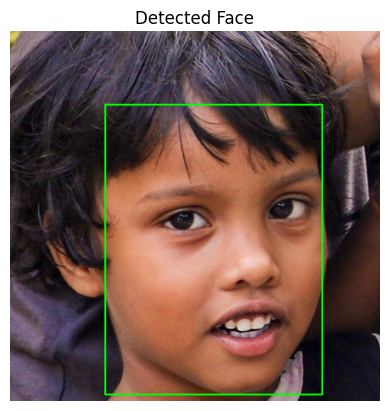

In [14]:
import cv2
from mtcnn.mtcnn import MTCNN
import matplotlib.pyplot as plt


real_image_path = os.path.join(data_path, 'training_real', 'real_00001.jpg')


img = cv2.imread(real_image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

detector = MTCNN()
faces = detector.detect_faces(img_rgb)


for face in faces:
    x, y, w, h = face['box']
    cv2.rectangle(img_rgb, (x, y), (x + w, y + h), (0, 255, 0), 2)

plt.imshow(img_rgb)
plt.axis('off')
plt.title("Detected Face")
plt.show()


In [15]:
!pip install keras-facenet

  Preparing metadata (setup.py) ... done
  Created wheel for keras-facenet: filename=keras_facenet-0.3.2-py3-none-any.whl size=10368 sha256=0175011bb080445242fd9e80740784659e102a0ce08d7c40a87b323da8d22ef0
  Stored in directory: /root/.cache/pip/wheels/99/94/dd/cb1a65a7440ba6d508bd24346c15af0b1d24ff8b1cdb1c9959
Successfully built keras-facenet


In [16]:
from keras_facenet import FaceNet

embedder = FaceNet()
print("FaceNet model loaded!")

FaceNet model loaded!


In [18]:
x, y, w, h = faces[0]['box']
face_crop = img_rgb[y:y+h, x:x+w]

face_resized = cv2.resize(face_crop, (160, 160))

embedding = embedder.embeddings([face_resized])[0]

print("Face embedding shape:", embedding.shape)
print("First 5 values of fingerprint:\n", embedding[:5])

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Face embedding shape: (512,)
First 5 values of fingerprint:
 [ 0.00656086 -0.05142437 -0.03955213  0.0294618   0.03917639]


In [19]:
import pickle

output_path = '/content/drive/MyDrive/FaceRecognitionAnti-SpoofingSystem/outputs/real_00001_embedding.pkl'

with open(output_path, 'wb') as f:
    pickle.dump(embedding, f)

print("Saved face fingerprint to:", output_path)


Saved face fingerprint to: /content/drive/MyDrive/FaceRecognitionAnti-SpoofingSystem/outputs/real_00001_embedding.pkl


Load and Detect Faces from two real images

In [26]:
import cv2
from mtcnn.mtcnn import MTCNN
from keras_facenet import FaceNet
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine

detector = MTCNN()
embedder = FaceNet()

def get_embedding(image_path):
  img = cv2.imread(image_path)
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  faces = detector.detect_faces(img_rgb)

  if faces:
    x, y, w, h = faces[0]['box']
    face_crop = img_rgb[y:y+h, x:x+w]
    face_resized = cv2.resize(face_crop, (160, 160))
    embedding = embedder.embeddings([face_resized])[0]
    return embedding
  else:
    print(f"No face found in {image_path}")
    return None


img1 = os.path.join(data_path, 'training_real', 'real_00001.jpg')
img2 = os.path.join(data_path, 'training_real', 'real_00002.jpg')

embedding1 = get_embedding(img1)
embedding2 = get_embedding(img2)

if embedding1 is not None and embedding2 is not None:
  similarity = 1 -cosine(embedding1, embedding2)
  print(f"\n Cosine Similarity: {similarity:.4f}")

  if similarity > 0.7:
    print("These images are ikely of the same person.")
  else:
    print("Thes images are ikely of different people.")








1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step

 Cosine Similarity: -0.0593
Thes images are ikely of different people.


In [27]:
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
import numpy as np
import cv2
import os


real_folder = os.path.join(data_path, 'training_real')
fake_folder = os.path.join(data_path, 'training_fake')

real_files = os.listdir(real_folder)[:500]
fake_files = os.listdir(fake_folder)[:500]

data = []
labels = []


for file in real_files:
    path = os.path.join(real_folder, file)
    img = cv2.imread(path)
    img = cv2.resize(img, (160, 160))
    img = img_to_array(img) / 255.0
    data.append(img)
    labels.append(1)


for file in fake_files:
    path = os.path.join(fake_folder, file)
    img = cv2.imread(path)
    img = cv2.resize(img, (160, 160))
    img = img_to_array(img) / 255.0
    data.append(img)
    labels.append(0)


data = np.array(data)
labels = np.array(labels)


X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

print(f"Data loaded! Training samples: {len(X_train)}, Testing samples: {len(X_test)}")


Data loaded! Training samples: 800, Testing samples: 200


In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(160, 160, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 158, 158, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 79, 79, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 77, 77, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 38, 38, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 92416)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,829,376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,848,897 (45.20 MB)

 Trainable params: 11,848,897 (45.20 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=32)


Epoch 1/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 64s 3s/step - accuracy: 0.4947 - loss: 1.9152 - val_accuracy: 0.5000 - val_loss: 0.6930
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.5840 - loss: 0.6904 - val_accuracy: 0.5600 - val_loss: 0.6929
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.6474 - loss: 0.6715 - val_accuracy: 0.4600 - val_loss: 0.7022
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.6624 - loss: 0.6492 - val_accuracy: 0.5200 - val_loss: 0.7388
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.7558 - loss: 0.5583 - val_accuracy: 0.5350 - val_loss: 0.8217


In [30]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 958ms/step - accuracy: 0.5497 - loss: 0.8025
🎯 Test Accuracy: 53.50%


In [35]:

def predict_real_or_fake(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (160, 160))
    img = img_to_array(img) / 255.0
    img = np.expand_dims(img, axis=0)

    prediction = model.predict(img)[0][0]
    print(f"🔍 Prediction score: {prediction:.4f}")

    if prediction > 0.5:
        print("This face is REAL.")
    else:
        print("This face is FAKE.")

predict_real_or_fake(os.path.join(data_path, 'training_fake', 'easy_100_1111.jpg'))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step
🔍 Prediction score: 0.3802
This face is FAKE.
